In the [previous step](./DataEnrichment.ipynb) we have retrieved the needed movie data from the MovieLens project and TMDB. The result was saved in **extended_movie_data_with_local_files.csv**

The goal of this notebook is to analyze the data, filter the data if necessary and to bring it into a state that can be used conviniontly in the [training step](./Training.ipynb).

## Preamble

In [12]:
import pandas as pd
import numpy as np
from IPython.display import display
import helpers

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
movies = pd.read_csv(os.path.join('data', 'extended_movie_data_with_local_files.csv'), index_col='movieId', sep=';')
display(movies.head(3))
movies.shape

,title,genres,tmdbId,release_year,poster_url,language,local_poster_file
movieId,,,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862,1995,https://image.tmdb.org/t/p/w300/rhIRbceoE9lR4v...,en,1.jpg
2,Jumanji (1995),Adventure|Children|Fantasy,8844,1995,https://image.tmdb.org/t/p/w300/vgpXmVaVyUL7GG...,en,2.jpg
3,Grumpier Old Men (1995),Comedy|Romance,15602,1995,https://image.tmdb.org/t/p/w300/6ksm1sjKMFLbO7...,en,3.jpg


(27026, 7)

Drop all rows where at least one necessary information is not present

In [14]:
movies = movies[~(movies == 'not found').any(axis=1)]
movies.shape

(26659, 7)

Remove all unnecessary columns:

In [15]:
movies = movies[['title', 'genres', 'release_year', 'language', 'local_poster_file']]
movies.head(3)

,title,genres,release_year,language,local_poster_file
movieId,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,en,1.jpg
2,Jumanji (1995),Adventure|Children|Fantasy,1995,en,2.jpg
3,Grumpier Old Men (1995),Comedy|Romance,1995,en,3.jpg


## Data Analysis

### Style of posters differs based on country and time period

Let's take a look to three typical posters for the respective time, The greate dictator from 1940, Rocky 2 from 1979, and Sharktopus vs Pteracuda from 2014. The design techniques differ a lot: The Great Dictator poster is like most posters of the time **drawn**, Rocky 2 is a slightly altered **photograph**, and Sharktopus vs Pteracuda is the whole **photoshop** glory of our time.

<div style="display:flex">
<img src="posters/1281.jpg" alt="Drawing" style="width: 200px"/>
<img src="posters/2409.jpg" alt="Drawing" style="width: 200px;flex:1"/>
<img src="posters/113130.jpg" alt="Drawing" style="width: 200px;flex:2"/>
</div>

We can expect similar differences in styling for different countries as well, e.g. an adult targeted anime like Akira (Japan) could be mistaken for a children targeted cartoon in the west. To capture such differences our Deep Neural Network needs to see enough examples for every country and year. So let's take a look at the distribution of our movies per release year and country.

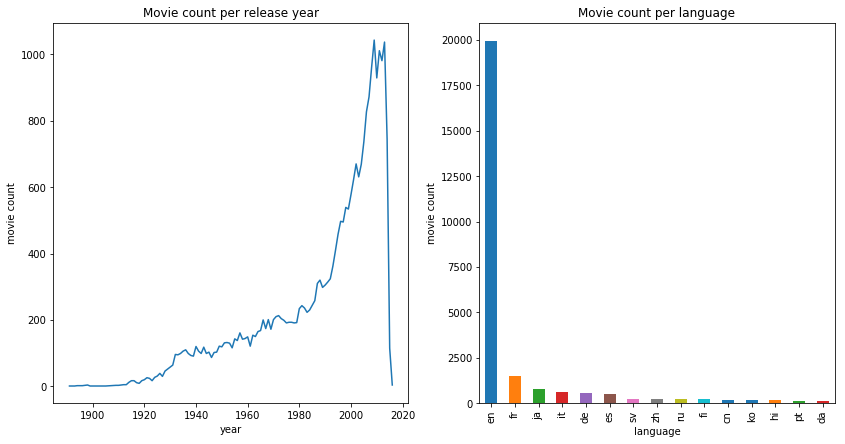

In [16]:
helpers.visualize_count_per_year_language(movies)

We see that our dataset is highly unbalanced for release year and language. Obviously the most common language is english and the count of releases increases highly with every year (with some stagnation for the last couple years). There are multiple possibilities to handle this issue, but as our goal is not to create the best possible classifier, but rather to combine multiple weak classifiers, I will just drop all non-english movies and also movies created before 1995. My hope is that this will create a somewhat simple, consistent and balanced dataset. 

In [17]:
movies = movies.dropna()
movies = movies[movies.language == 'en']
movies['release_year'] = pd.to_numeric(movies.release_year)
movies = movies[(movies.release_year >= 1995)]
movies.shape
assert np.array_equal(movies.shape, movies.dropna().shape)

### Movie Genres Analysis

The genres list in our data is a | separated string. First I am going to translate this string to a python list to simplify the handling.

In [18]:
def split_and_sort(genres_string):
    t = genres_string.split('|')
    t.sort()
    return t

movies.genres = movies.genres.apply(lambda x: split_and_sort(x))
movies.head(3)

,title,genres,release_year,language,local_poster_file
movieId,,,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,en,1.jpg
2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995,en,2.jpg
3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,en,3.jpg


Now let's take a look how often each movie genre occurs in the dataset

In [19]:
genre_counts = helpers.calc_genre_counts(movies.genres)
genre_counts

,count,distribution
genre,,
Drama,4809,0.216115
Comedy,3506,0.157559
Thriller,2204,0.099047
Documentary,1719,0.077251
Action,1508,0.067769
Romance,1474,0.066241
Horror,1162,0.052220
Crime,1154,0.051861
Adventure,903,0.040581


Some genres are almost non present in our dataset, e.g. Film Noir or Westerns. Again to create a somewhat balanced dataset by dropping all genres that take less than 5% of all occurences. 

In [20]:
genres_to_keep = set(genre_counts[genre_counts['distribution'] >= .05].index)
genres_to_keep

{'Action',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Horror',
 'Romance',
 'Thriller'}

In [21]:
movies['relevant_genres'] = movies['genres'].apply(lambda x: [genre for genre in x if genre in genres_to_keep]) 
movies = movies[movies.relevant_genres.map(len) > 0]
display(movies.head())
print(movies.shape)

,title,genres,release_year,language,local_poster_file,relevant_genres
movieId,,,,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,en,1.jpg,[Comedy]
3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,en,3.jpg,"[Comedy, Romance]"
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,en,4.jpg,"[Comedy, Drama, Romance]"
5,Father of the Bride Part II (1995),[Comedy],1995,en,5.jpg,[Comedy]
6,Heat (1995),"[Action, Crime, Thriller]",1995,en,6.jpg,"[Action, Crime, Thriller]"


(10649, 6)


In [22]:
helpers.calc_genre_counts(movies.relevant_genres)

,count,distribution
genre,,
Drama,4809,0.274236
Comedy,3506,0.199932
Thriller,2204,0.125684
Documentary,1719,0.098027
Action,1508,0.085995
Romance,1474,0.084056
Horror,1162,0.066264
Crime,1154,0.065807


### Movie Tags Analysis

In [56]:
import os
import string

tags = pd.read_csv(os.path.join('data', 'ml-20m', 'tags.csv'), sep=',')
print('Count of tags for all movies: {}'.format(tags.shape[0]))
tags.head()

Count of tags for all movies: 465564


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


Keep only relevant columns, drop NAN rows, and keep only tags for movies we have in the current dataset.

In [57]:
tags = tags[['movieId', 'tag']]
tags = tags.dropna()
print('Tags count without NANs: {}'.format(tags.shape[0]))
tags = pd.merge(movies, tags, on='movieId', how='inner')[['movieId', 'tag']]
print('Tags count for movies present in prefiltered movies set: {}'.format(tags.shape[0]))

Tags count without NANs: 465548
Tags count for movies present in prefiltered movies set: 270633


Normalize tags, i.e. lowercase strings, remove punctuation, etc.

In [58]:
def normalize_tag(tag):
    tag = tag.lower()
    rem_punctuation_trans = str.maketrans('', '', string.punctuation)
    tag = tag.translate(rem_punctuation_trans)
    return tag

tags['tag'] = tags['tag'].map(lambda x: normalize_tag(x))
display(tags.head(3))
print(tags.shape)


,movieId,tag
0,1,watched
1,1,computer animation
2,1,disney animated feature


(270633, 2)


Let's look at the occurance counts for each tag.

In [59]:
pd.options.display.max_rows = 20
helpers.calc_counts(tags['tag'], 'tag')

,count,distribution
tag,,
scifi,2500,0.009238
action,2210,0.008166
twist ending,2014,0.007442
comedy,1945,0.007187
funny,1748,0.006459
based on a book,1733,0.006404
nudity topless,1695,0.006263
atmospheric,1536,0.005676
surreal,1501,0.005546


The first thing that strikes is that some movie genres are also present as tags, e.g. comedy as the fourth element in the previous list. We should drop these tags.

In [60]:
genre_counts = helpers.calc_genre_counts(movies.genres)
movie_genres_lowered = [genre.lower() for genre in genre_counts.index]
tags = tags[~tags['tag'].isin(movie_genres_lowered)]
tags.shape

(258448, 2)

Deep Learning requires a large set of examples to be able to actually learn something. Some tags occur only a couple of times in our dataset. The easiest solution is to drop these and to consider only a couple hundred most common tags. 

In [61]:
nlargest_tags = tags['tag'].value_counts().nlargest(400).index
tags = tags[tags['tag'].isin(nlargest_tags)]
print(tags.shape)

(131079, 2)


In [62]:
tags['tag'].value_counts()
print('Count of movies with at least a single tag: {}'.format(len(tags.index.unique())))

Count of movies with at least a single tag: 131079


Lets look at a couple examples for tag distributions per movie

In [66]:
grouped_tags = tags.groupby(tags.columns.tolist()).size()

pd.options.display.max_rows = 30
grouped_tags.to_frame().head(30).rename(columns={0: 'count'})

count
movieId tag                
1       3d                3
        bdvideo           1
        cgi               4
        classic           7
        clever            5
        clv               1
        cute              1
        disney           28
        dvdvideo          1
        erlends dvds      1
        family           12
        friendship        2
        fun               2
        funny            18
        humorous         11
        imdb top 250      5
        pixar            79
        story             1
        time travel      11
        tom hanks        23
        watched           1
        witty            14
3       clv               1
        sequel            2
4       chick flick       2
        clv               1
        revenge           1
5       clv               1
        family            2
        pregnancy         2

Some tags occur only once per movie. These tags could be erronous entries or they could be human misclassification

In [88]:
grouped_tags = grouped_tags[grouped_tags >= 2]
grouped_tags.head(30)

movieId  tag            
1        3d                  3
         cgi                 4
         classic             7
         clever              5
         disney             28
         family             12
         friendship          2
         fun                 2
         funny              18
         humorous           11
         imdb top 250        5
         pixar              79
         time travel        11
         tom hanks          23
         witty              14
3        sequel              2
4        chick flick         2
5        family              2
         pregnancy           2
6        adultery            2
         al pacino          24
         atmospheric        10
         dialogue            5
         great acting       10
         imdb top 250        5
         long                6
         los angeles         5
         natalie portman     7
         overrated           8
         philosophy          6
dtype: int64

In [89]:
print('Count of movies with at least one tag: {}'.format(len(grouped_tags.index.get_level_values(level='movieId').unique())))

Count of movies with at least one tag: 3318


The last thing I am going to do is to add the tags for every movie to the *movies* dataset and to cache the result.

In [94]:
movies['tags'] = build_tags_column(movies, grouped_tags)
movies.head(3)

,title,genres,release_year,language,local_poster_file,relevant_genres,tags
movieId,,,,,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,en,1.jpg,[Comedy],"[3d, cgi, classic, clever, disney, family, fri..."
3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,en,3.jpg,"[Comedy, Romance]",[sequel]
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,en,4.jpg,"[Comedy, Drama, Romance]",[chick flick]


In [95]:
movies.to_csv(os.path.join('data', 'movie_training_data.csv'))

In [96]:
pd.read_csv(os.path.join('data', 'movie_training_data.csv'), index_col='movieId').head(3)

,title,genres,release_year,language,local_poster_file,relevant_genres,tags
movieId,,,,,,,
1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy...",1995,en,1.jpg,['Comedy'],"['3d', 'cgi', 'classic', 'clever', 'disney', '..."
3,Grumpier Old Men (1995),"['Comedy', 'Romance']",1995,en,3.jpg,"['Comedy', 'Romance']",['sequel']
4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']",1995,en,4.jpg,"['Comedy', 'Drama', 'Romance']",['chick flick']
